In [13]:
import pandas as pd
import os
import numpy as np
import json
from scipy.stats import iqr
import matplotlib.pyplot as plt

In [14]:
# Definiere die relevanten Stats (Spaltennamen in deiner CSV):
relevant_stats = [
    "total_kills",
    "total_deaths",
    "total_time_played",
    "total_wins",
    "total_kills_headshot",
    "total_shots_hit",
    "total_shots_fired",
    "total_rounds_played",
    "total_matches_won",
    "total_matches_played",
    "total_gg_matches_won",
    "total_gg_matches_played",
    #"stat_player_deaths"
]

# Pfad zu deiner CSV-Datei
csv_file = r"C:\Users\paulu\OneDrive\Dokumente\GitHub\WebMining\Paul\Analyse\Counter-Strike_2_stats.csv"  # Beispielname

# DataFrame einlesen
df = pd.read_csv(csv_file)

In [15]:
# Fehlende Werte **nicht global löschen**, sondern pro Stat einzeln betrachten
# -------------------------------
# 3) K/D-RATIO BERECHNEN
# -------------------------------
if "total_kills" in df.columns and "total_deaths" in df.columns:
    df["KD_ratio"] = df["total_kills"] / df["total_deaths"]
    df["KD_ratio"] = df["KD_ratio"].replace([np.inf, -np.inf], np.nan)  # Inf-Werte durch NaN ersetzen
    relevant_stats.append("KD_ratio")  # Füge die K/D-Statistik zur Analyse hinzu

In [16]:
# -------------------------------
# 4) FUNKTIONEN FÜR IQR-BEREINIGUNG UND PERZENTILE
# -------------------------------
def remove_outliers_iqr(series):
    """
    Entfernt Ausreißer mithilfe des Interquartilsabstands (IQR).
    Gibt die bereinigte Series und die Anzahl der entfernten Werte zurück.
    """
    data = series.dropna().to_numpy()
    if len(data) < 4:
        return series, 0  # Keine Werte oder zu wenige für IQR-Berechnung

    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr_value = iqr(data)  # aus scipy.stats
    lower_bound = q1 - 1.5 * iqr_value
    upper_bound = q3 + 1.5 * iqr_value
    
    # Maske der Werte, die im akzeptablen Bereich liegen
    mask = (series >= lower_bound) & (series <= upper_bound)
    removed_count = (~mask).sum()
    cleaned_series = series[mask]
    
    return cleaned_series, removed_count

In [17]:
#Perzentile berechnen und Ausreißer entfernen
def calculate_percentiles(values, ptiles=[0, 25, 50, 75, 100, 80, 90, 95, 99]):
    """
    Berechnet die angegebenen Perzentile für eine gegebene Werte-Serie.
    """
    result = {}
    data = values.dropna().to_numpy()
    for p in ptiles:
        result[f"{p}%"] = np.percentile(data, p)
    return result

# -------------------------------
# 5) AUSWERTUNG PRO SPALTE
# -------------------------------
results = {}         # Perzentil-Ergebnisse pro Statistik
exclusion_stats = {} # Daten zum Ausschluss (Anzahl/Werte)

for stat in relevant_stats:
    if stat not in df.columns:
        continue  # Falls Spalte fehlt
    
    series = df[stat].dropna()
    if series.empty:
        continue
    
    # Ausreißer entfernen
    cleaned_series, removed_count = remove_outliers_iqr(series)
    original_count = len(series)
    cleaned_count = len(cleaned_series)
    
    if cleaned_count == 0:
        continue  # Alles wurde entfernt
    
    # Perzentile berechnen
    stat_percentiles = calculate_percentiles(cleaned_series)
    
    # Ergebnisse ablegen
    results[stat] = stat_percentiles
    exclusion_stats[stat] = {
        "original_count": original_count,
        "cleaned_count": cleaned_count,
        "removed_count": removed_count,
        "percent_excluded": (removed_count / original_count) * 100
    }

Die zusammengefassten Perzentile wurden in 'stats_percentiles.csv' gespeichert.


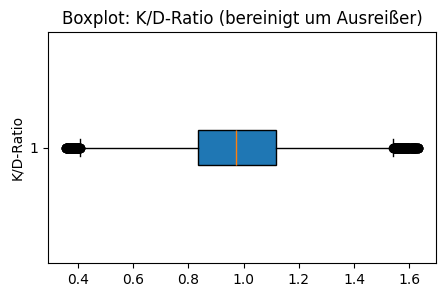

In [19]:
# -------------------------------
# 6) ERGEBNISSE IN CSV SCHREIBEN
# -------------------------------
rows_for_csv = []

for stat, stat_percentiles in results.items():
    row = {
        "stat": stat,
        "original_count": exclusion_stats[stat]["original_count"],
        "cleaned_count": exclusion_stats[stat]["cleaned_count"],
        "removed_count": exclusion_stats[stat]["removed_count"],
        "percent_excluded": exclusion_stats[stat]["percent_excluded"]
    }
    # Perzentile anhängen
    for p_label, p_value in stat_percentiles.items():
        row[p_label] = p_value
    
    rows_for_csv.append(row)

# DataFrame aus den Auswertungsergebnissen
results_df = pd.DataFrame(rows_for_csv)
results_df.to_csv("csgo_percentiles.csv", index=False)
print("Die zusammengefassten Perzentile wurden in 'stats_percentiles.csv' gespeichert.")

# -------------------------------
# 7) BEISPIEL: BOX PLOT FÜR "KD_ratio"
# -------------------------------
if "KD_ratio" in df.columns:
    # Daten erneut aus "df" nehmen
    # und die IQR-Bereinigung anwenden (damit der Boxplot ohne Ausreißer gemalt wird)
    kd_series = df["KD_ratio"].dropna()
    cleaned_series_kd, _ = remove_outliers_iqr(kd_series)
    
    # Matplotlib-Boxplot zeichnen
    plt.figure(figsize=(5, 3))
    plt.boxplot(cleaned_series_kd, vert=False, patch_artist=True)
    plt.title("Boxplot: K/D-Ratio (bereinigt um Ausreißer)")
    plt.ylabel("K/D-Ratio")
    plt.show()


In [11]:
#display all max and min values as well as the difference between them
for stat in relevant_stats:
    print(f"Statistik: {stat}")
    print(f"  Max: {df[stat].max()}")
    print(f"  Min: {df[stat].min()}")
    print(f"  Difference: {df[stat].max() - df[stat].min()}")
    print()

Statistik: total_kills
  Max: 1000001355.0
  Min: 0.0
  Difference: 1000001355.0

Statistik: total_deaths
  Max: 100017938.0
  Min: 0.0
  Difference: 100017938.0

Statistik: total_time_played
  Max: 2036165379.0
  Min: 0.0
  Difference: 2036165379.0

Statistik: total_wins
  Max: 1000000866.0
  Min: 0.0
  Difference: 1000000866.0

Statistik: total_kills_headshot
  Max: 1000000711.0
  Min: 0.0
  Difference: 1000000711.0

Statistik: total_shots_hit
  Max: 1000003469.0
  Min: 0.0
  Difference: 1000003469.0

Statistik: total_shots_fired
  Max: 1000008962.0
  Min: 0.0
  Difference: 1000008962.0

Statistik: total_rounds_played
  Max: 1000001876.0
  Min: 0.0
  Difference: 1000001876.0

Statistik: total_matches_won
  Max: 100000465.0
  Min: 0.0
  Difference: 100000465.0

Statistik: total_matches_played
  Max: 100000934.0
  Min: 0.0
  Difference: 100000934.0

Statistik: total_gg_matches_won
  Max: 15015.0
  Min: 0.0
  Difference: 15015.0

Statistik: total_gg_matches_played
  Max: 15323.0
  Min: 